In [23]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn import tree
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from scipy.stats import norm,skew,boxcox
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
from imblearn import under_sampling

In [24]:
#loading intermediate dataset ukbms and haduk, created in  HADUK_intermediate.py and UKBMS_HADUK_Exploration.ipynb
df = pd.read_csv('BioD_year_site_latlong.csv')
df.drop(columns=df.columns[0], inplace = True)
df2 = df[df['Simpsons Index'] != 1] 
df2 = df[df['Simpsons Index'] != 0]

Text(0.5, 1.0, 'Boxplot of climatic variables')

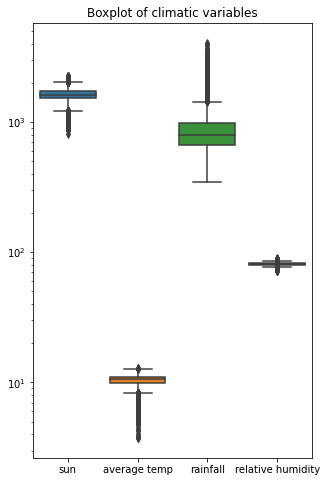

In [25]:
df1_climate = df.drop(columns=['Simpsons Index','SPECIES RICHNESS','TOTAL SITE INDEX','Site Number', 'YEAR', 'Easting','Northing','latitude','longitude'])
df1_climate.describe()

fig,ax = plt.subplots(figsize=(5,8))
bxplot = sns.boxplot(data=df1_climate)
bxplot.set_yscale('log')
plt.title('Boxplot of climatic variables')

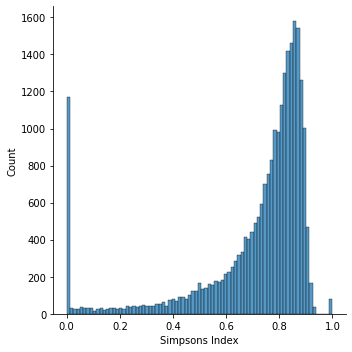

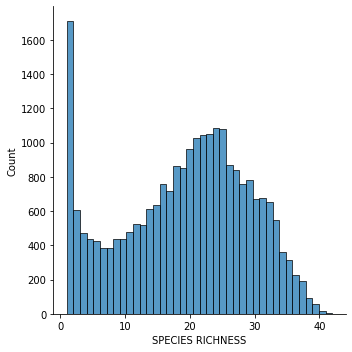

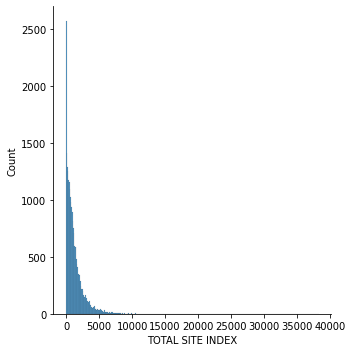

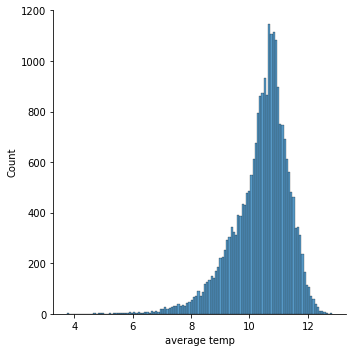

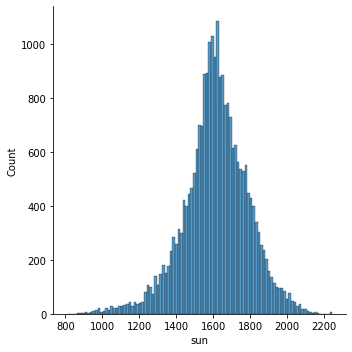

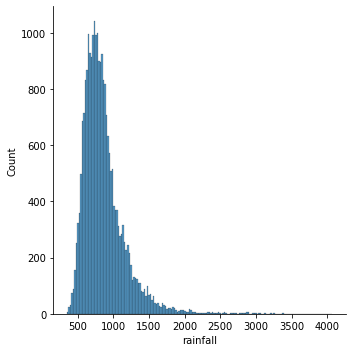

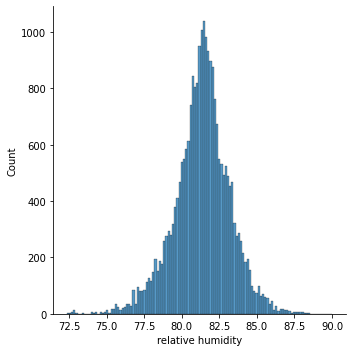

In [26]:
sns.displot(df['Simpsons Index'])
sns.displot(df['SPECIES RICHNESS'])
sns.displot(df['TOTAL SITE INDEX'])
sns.displot(df['average temp'])
sns.displot(df['sun'])
sns.displot(df['rainfall'])
sns.displot(df['relative humidity'])

Multiple Linear Regression, carried out on climatic variables (x) and total site index (abundance metric) (y):


In [27]:
x = df[['sun','average temp','rainfall','relative humidity']]
y= df[['TOTAL SITE INDEX']]
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3) #split into training and testing sets

<AxesSubplot:>

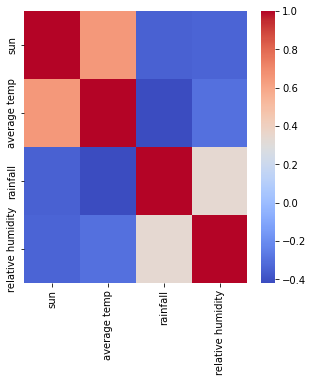

In [28]:
corr = x_train.corr()
plt.figure(figsize=(5,5))
sns.heatmap(corr, cmap='coolwarm')

In [29]:

x_train.drop(columns=['sun'],inplace=True)
x_test.drop(columns=['sun'],inplace=True)

In [30]:
#training multiple linear regression model 
model = LinearRegression()
model.fit(x_train, np.log(y_train))
print(model.coef_)
print(model.intercept_)

[[ 0.11251916 -0.00059599 -0.04834745]]
[9.68560248]


In [31]:
preds_SR = model.predict(x_test)

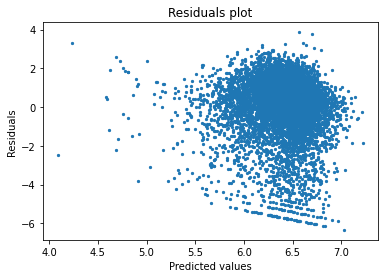

In [32]:
#plotting residuals
residuals = np.log(y_test)-preds_SR
plt.scatter(preds_SR,residuals,5)
plt.ylabel('Residuals')
plt.xlabel('Predicted values')
plt.title('Residuals plot')
plt.show()

In [33]:
mse = metrics.mean_squared_error(np.log(y_test),preds_SR)
r2 = metrics.r2_score(np.log(y_test),preds_SR)
print(mse)
print(np.sqrt(mse))
print(r2)

2.337137426994096
1.5287699064915217
0.027561924876753685


In [34]:
#Checking diversity
x = df[['average temp','rainfall','relative humidity']]
y= df[['Simpsons Index']]
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3)
model1 = LinearRegression()
model1.fit(x_train, y_train)
print(model1.coef_)
print(model1.intercept_)
preds_Div = model1.predict(x_test)
mse = metrics.mean_squared_error(y_test,preds_Div)
r2 = metrics.r2_score(y_test,preds_Div)
print('mse: ' + str(mse))
print('rmse: ' + str(np.sqrt(mse)))
print('r2: ' + str(r2))

[[ 7.35668702e-03 -8.17699245e-05 -9.54312754e-03]]
[1.48193043]
mse: 0.05065707615156871
rmse: 0.2250712690495362
r2: 0.033399246601247934


Decision Tree:


In [35]:
x3 = df[['sun','average temp','rainfall','relative humidity']]
x_train3,x_test3,y_train3,y_test3 = train_test_split(x3,y,test_size=0.3, random_state=44) #split into training and testing sets


/var/folders/dm/ys_v7_dn4p7d13d409tlwpt00000gn/T/ipykernel_38388/3113692524.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  reg.fit(x_train3,y_train3)


<AxesSubplot:>

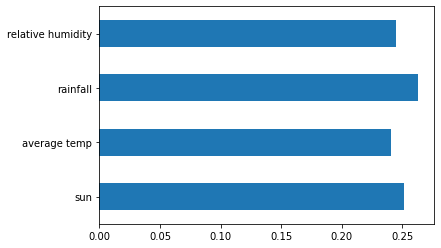

In [36]:
# #decision tree hyperparameter tuning
reg = ExtraTreesRegressor()
reg.fit(x_train3,y_train3)
feat_importances = pd.Series(reg.feature_importances_,index=x_train3.columns)
feat_importances.plot(kind='barh') #finding which features are most important for the model

In [37]:
model_tree = tree.DecisionTreeRegressor()
model_tree.fit(x_train3,y_train3)

DecisionTreeRegressor()

In [38]:
preds_tree = model_tree.predict(x_test3)

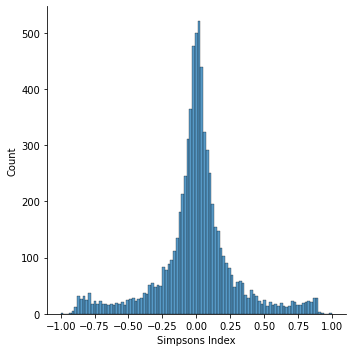

In [39]:
y_test3a = y_test3.squeeze()
sns.displot(y_test3a-preds_tree)

Text(0, 0.5, 'Predicted')

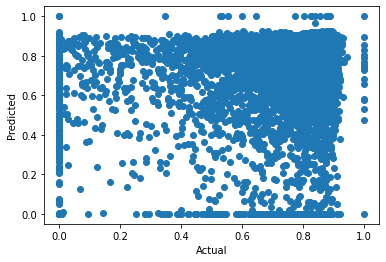

In [40]:
plt.scatter(y_test3,preds_tree)
plt.xlabel('Actual')
plt.ylabel('Predicted')

In [41]:
mse_tree = metrics.mean_squared_error(y_test3,preds_tree)
print(mse_tree)
print(np.sqrt(mse_tree))

0.08315866014046036
0.28837243304529014


In [42]:
#hyperparameter tuning 
parameters={"splitter":["best","random"],
            "max_depth" : [1,3,5,7,9,11],
           "min_samples_leaf":[1,3,5,7,9],
           "min_weight_fraction_leaf":[0.1,0.2,0.3,0.4],
           "max_features":[1,"log2","sqrt",None],
           "max_leaf_nodes":[None,10,30,50,70,90] }


In [43]:
tuning_model=GridSearchCV(model_tree,param_grid=parameters,scoring='neg_mean_squared_error',cv=3)
tuning_sample = df.sample(frac=0.3) #sampling dataset to prevent crashses when fitting tuning model
x_tuning = tuning_sample[['sun','average temp','relative humidity','rainfall']]
y_tuning = tuning_sample[['Simpsons Index']]

In [44]:
tuning_model.fit(x_tuning,y_tuning)

GridSearchCV(cv=3, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [1, 3, 5, 7, 9, 11],
                         'max_features': [1, 'log2', 'sqrt', None],
                         'max_leaf_nodes': [None, 10, 30, 50, 70, 90],
                         'min_samples_leaf': [1, 3, 5, 7, 9],
                         'min_weight_fraction_leaf': [0.1, 0.2, 0.3, 0.4],
                         'splitter': ['best', 'random']},
             scoring='neg_mean_squared_error')

In [45]:
print(tuning_model.best_params_)
print(tuning_model.best_score_)

{'max_depth': 9, 'max_features': 'log2', 'max_leaf_nodes': 70, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.1, 'splitter': 'best'}
-0.04877609632940815


In [46]:
model_tree_tuned = tree.DecisionTreeRegressor(max_depth=11,max_features='sqrt',max_leaf_nodes=90,min_samples_leaf=5,min_weight_fraction_leaf=0.1,splitter='best')
model_tree_tuned.fit(x_train3,y_train3)

DecisionTreeRegressor(max_depth=11, max_features='sqrt', max_leaf_nodes=90,
                      min_samples_leaf=5, min_weight_fraction_leaf=0.1)

In [47]:
preds_tuned = model_tree_tuned.predict(x_test3)
mse_tuned = metrics.mean_squared_error(y_test3,preds_tuned)
print(mse_tuned)
print(np.sqrt(mse_tuned))

0.0501433134474286
0.2239270270588805


Text(0, 0.5, 'Residuals')

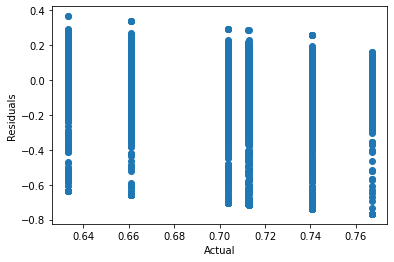

In [48]:
y_test3b = y_test3.squeeze()
resid = y_test3b-preds_tuned
plt.scatter(preds_tuned,resid)
plt.xlabel('Actual')
plt.ylabel('Residuals')

Decision tree classifier:

0.6824104234527687


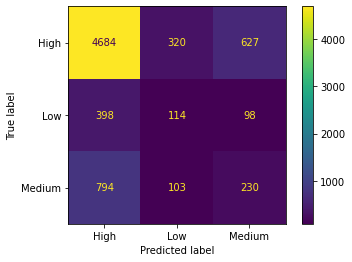

In [49]:
#multiclass classifcation decision tree classifier
x_c = df[['sun','average temp','rainfall','relative humidity']]
y_c = df[['Diversity']]
x_ctrain,x_ctest,y_ctrain,y_ctest = train_test_split(x_c,y_c,test_size=0.3,random_state=44)

dtree_model = tree.DecisionTreeClassifier()
dtree_model.fit(x_ctrain,y_ctrain)
dtree_preds = dtree_model.predict(x_ctest)

cm = metrics.confusion_matrix(y_ctest,dtree_preds)
acc = metrics.accuracy_score(y_ctest, dtree_preds)

metrics.ConfusionMatrixDisplay.from_predictions(y_ctest,dtree_preds)
print(acc)

In [50]:
#d tree classifier tunin
ctree_tuning = tree.DecisionTreeClassifier()
c_tuning_model=GridSearchCV(ctree_tuning,param_grid=parameters,scoring='accuracy',cv=3,verbose=3)
tuning_sample = df.sample(frac=0.3) #sampling dataset to prevent crashses when fitting tuning model
x_ctuning = tuning_sample[['sun','average temp','relative humidity','rainfall']]
y_ctuning = tuning_sample[['Diversity']]

In [51]:
c_tuning_model.fit(x_ctuning,y_ctuning) 

Fitting 3 folds for each of 5760 candidates, totalling 17280 fits
[CV 1/3] END max_depth=1, max_features=1, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.769 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=1, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.769 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=1, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.769 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=1, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random;, score=0.769 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=1, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random;, score=0.769 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=1, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random;,

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [1, 3, 5, 7, 9, 11],
                         'max_features': [1, 'log2', 'sqrt', None],
                         'max_leaf_nodes': [None, 10, 30, 50, 70, 90],
                         'min_samples_leaf': [1, 3, 5, 7, 9],
                         'min_weight_fraction_leaf': [0.1, 0.2, 0.3, 0.4],
                         'splitter': ['best', 'random']},
             scoring='accuracy', verbose=3)

In [52]:
print(c_tuning_model.best_params_)
print(c_tuning_model.best_score_)

{'max_depth': 1, 'max_features': 1, 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.1, 'splitter': 'best'}
0.769105461830871


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


0.7642508143322475


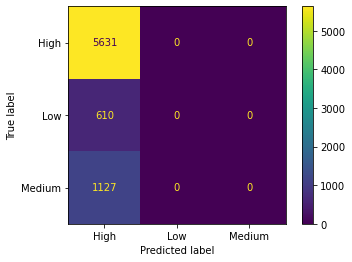

In [53]:
tuned_ctree = tree.DecisionTreeClassifier(max_depth=1,max_features='auto',max_leaf_nodes=None,min_samples_leaf=1,min_weight_fraction_leaf=0.1,splitter='best')
tuned_ctree.fit(x_ctrain,y_ctrain) 
tuned_ctree_preds = tuned_ctree.predict(x_ctest)

acc = metrics.accuracy_score(y_ctest, tuned_ctree_preds)

metrics.ConfusionMatrixDisplay.from_predictions(y_ctest,tuned_ctree_preds)
print(acc)

KNN CLASSIFICATION:

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


0.7607220412595005


0.6743548782062548

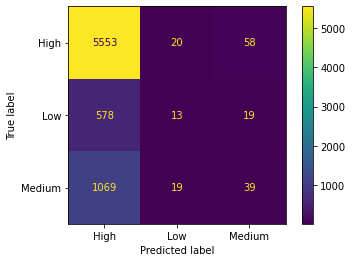

In [54]:
#multiclass classifcation k-nearest neighbours
knn_model = KNeighborsClassifier(n_neighbors = 10).fit(x_ctrain,y_ctrain)
#accuracy = knn_model.score(x_ctest,y_ctest)

knn_preds = knn_model.predict(x_ctest)
cm_knn = metrics.confusion_matrix(y_ctest,knn_preds)
acc_knn =metrics.accuracy_score(y_ctest,knn_preds)

metrics.ConfusionMatrixDisplay.from_predictions(y_ctest,knn_preds)
print(acc_knn)
metrics.f1_score(y_ctest,knn_preds, average='weighted')

KNN SCALED X VARIABLES:

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


0.748371335504886


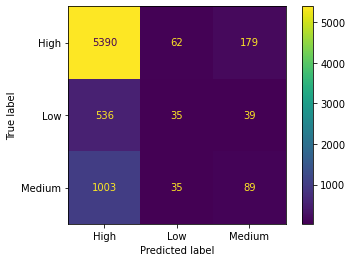

In [55]:
#scaled knn
scaler = StandardScaler()
df_scale = df.copy()
features = [['sun','average temp','rainfall','relative humidity']]
for feature in features:
    df_scale[feature] = scaler.fit_transform(df_scale[feature])

x_scaled  = df_scale[['sun','average temp','rainfall','relative humidity']]
y_s = df_scale[['Diversity']]

x_strain,x_stest,y_strain,y_stest = train_test_split(x_scaled,y_s,test_size=0.3,random_state=44)
knn_scaled_model = KNeighborsClassifier()
knn_scaled_model.fit(x_strain,y_strain)

knn_scaled_preds = knn_scaled_model.predict(x_stest)
acc_scaled = metrics.accuracy_score(y_stest,knn_scaled_preds)

metrics.ConfusionMatrixDisplay.from_predictions(y_stest,knn_scaled_preds)
print(acc_scaled)


In [56]:
metrics.f1_score(y_stest,knn_scaled_preds, average='weighted')

0.682738313321154

In [66]:
#knn  hyperparameter tuning
n_neighbors = [5,10,15,20,25,30]
leaf_size= list(range(1,25)) 
p=[1,2]

knn_hyperparameters = dict(n_neighbors=n_neighbors,leaf_size=leaf_size,p=p)
knn_tuned = KNeighborsClassifier()
knn_tuned_model = GridSearchCV(knn_tuned,knn_hyperparameters, cv=3)

In [68]:
knn_tuned_model.fit(x_strain,y_strain.values.ravel())
print('best leaf size:', knn_tuned_model.best_estimator_.get_params()['leaf_size'])
print('best p:', knn_tuned_model.best_estimator_.get_params()['p'])
print('best n_neighbors:', knn_tuned_model.best_estimator_.get_params()['n_neighbors'])


best leaf size: 2
best p: 1
best n_neighbors: 30


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


0.7658794788273615
0.6733164631286662


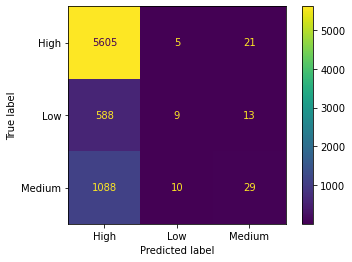

In [83]:
tuned_knn_model = KNeighborsClassifier(leaf_size=2,p=1,n_neighbors=30)
tuned_knn_model.fit(x_strain,y_strain)
tuned_knn_preds = tuned_knn_model.predict(x_stest)

acc_tuned_knn = metrics.accuracy_score(y_stest,tuned_knn_preds)

metrics.ConfusionMatrixDisplay.from_predictions(y_stest,tuned_knn_preds)
print(acc_tuned_knn)
print(metrics.f1_score(y_stest,tuned_knn_preds, average='weighted'))

Condensed Neareset Neighbor Undersamling:

In [70]:
undersample = under_sampling.CondensedNearestNeighbour()
x_under,y_under = undersample.fit_resample(x_strain,y_strain)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


0.7566503800217155


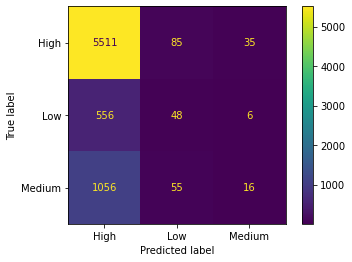

In [82]:
cnn_knn = KNeighborsClassifier(leaf_size=2,p=1,n_neighbors=30)
cnn_knn.fit(x_under,y_under)
cnn_knn_preds = cnn_knn.predict(x_stest)


acc_knn_cnn = metrics.accuracy_score(y_stest,cnn_knn_preds)
metrics.ConfusionMatrixDisplay.from_predictions(y_stest,cnn_knn_preds)
print(acc_knn_cnn)